# Demand Forecast: LSTM Model

In [1]:
# Import necessary libraries
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from kerastuner.tuners import Hyperband
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from scipy.stats import skewnorm
from sklearn.model_selection import train_test_split
import re
import json
import pickle
import os

/var/folders/x4/_l78dvs92m346fbfkb6pl1h40000gn/T/ipykernel_51587/2304321488.py:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


### scrapping weather data

In [3]:
def read_weather_data():
    try:
        # Open the JSON file
        with open('next_7_day.json', 'r') as file:
            # Load data from the JSON file
            weather_data = json.load(file)
        
        # Print the weather data
        for entry in weather_data:
            print(entry)
    except FileNotFoundError:
        print("File not found. Please check the filename and try again.")
    except json.JSONDecodeError:
        print("Error decoding JSON. Please check the JSON file for errors.")

# Run the function
# read_weather_data()


### weather data processing

In [4]:
def weather_data_processing():
    data = json.load(open('next_7_day.json'))
    df = pd.DataFrame(data)
    df = df.iloc[0:7]
    df['heavy_rainfall_flg'] = np.where(df['weatherCondition'].str.contains('shower|storm',case=False), 1, 0)
    df.drop(columns=['feelsLike','weatherIcon','wind','humidity','precipitationChance','precipitationAmount','description'], inplace=True)

    def clean_text(text):
        """Remove HTML tags and unwanted spaces from text."""
        text = re.sub('<[^<]+?>', '', text) 
        text = text.replace('&nbsp;', ' ')   
        text = re.sub('\s+', ' ', text)  
        return text.strip()
    
    df['temperature'] = df['temperature'].apply(clean_text)
    df['day'] = df['day'].apply(clean_text)
    
    
    today = datetime.now().date()
    df['date'] = [today + timedelta(days=i) for i in range(7)]
    df['date'] = pd.to_datetime(df['date'])

    df.drop(columns=['day'], inplace=True)

    df['max_temp'] = df['temperature'].str.slice(0,2)
    df['min_temp'] = df['temperature'].str.slice(4,7)
    df.drop(columns=['temperature'], inplace=True)


    df['max_temp'] = df['max_temp'].astype(int)
    df['min_temp'] = df['min_temp'].astype(int)
    df['Temperature'] = (df['max_temp'] + df['min_temp']) / 2

    df.drop(columns=['max_temp','min_temp'], inplace=True)
    return df

weather_df = weather_data_processing()

### prepare sg public holiday dataset in 2024

In [5]:
def generate_holiday_df(year):
    import datetime  # Importing datetime module within the function scope
    start_date = datetime.date(year, 1, 1)
    end_date = datetime.date(year, 12, 31)

    # List of holidays in Singapore for the given year
    holidays_sg = [
        datetime.date(year, 1, 1), datetime.date(year, 2, 10), datetime.date(year, 2, 11),
        datetime.date(year, 3, 29), datetime.date(year, 4, 10), datetime.date(year, 5, 1),
        datetime.date(year, 5, 20), datetime.date(year, 6, 17), datetime.date(year, 8, 9),
        datetime.date(year, 10, 31), datetime.date(year, 12, 25)
    ]

    # Dictionary to convert day names to numbers
    day_to_number = {
        'Monday': 1,
        'Tuesday': 2,
        'Wednesday': 3,
        'Thursday': 4,
        'Friday': 5,
        'Saturday': 6,
        'Sunday': 7
    }

    holiday_sg_24 = []
    current_date = start_date
    while current_date <= end_date:
        day_of_week = current_date.strftime('%A')
        holiday_flg_sg = 1 if current_date in holidays_sg else 0
        holiday_sg_24.append([current_date.strftime('%Y-%m-%d'), day_of_week, holiday_flg_sg])
        current_date += datetime.timedelta(days=1)

    # Create DataFrame
    holiday_sg_24 = pd.DataFrame(holiday_sg_24, columns=['calendar_date', 'day_of_week', 'holiday_flg_sg'])

    # Map day_of_week from name to number
    holiday_sg_24['day_of_week'] = holiday_sg_24['day_of_week'].map(day_to_number)

    return holiday_sg_24

holiday_sg_24 = generate_holiday_df(2024)

### LSTM Model Training

#### 1. data preparation

In [6]:
def feature_engineering():
    visitor_data = pd.read_csv("../data/raw/synthetic_visit_data.csv")
    visitor_data['visit_date'] = pd.to_datetime(visitor_data['visit_date'])
    weather_data = pd.read_csv("../data/processed/weather_data_cleaned.csv")
    weather_data['Date'] = pd.to_datetime(weather_data['Date'])
    columns_to_drop = weather_data.columns[0:3].tolist()  # Dropping columns by indices
    weather_data.drop(columns=columns_to_drop, inplace=True)
    holiday_data = pd.read_csv("../data/raw/date_info_2324.csv")
    holiday_data['calendar_date'] = pd.to_datetime(holiday_data['calendar_date'])
    holiday_data.rename(columns={'calendar_date': 'calender_date'}, inplace=True)
    holiday_data.drop(columns="day_of_week", inplace=True)

    merged_data = pd.merge(visitor_data, weather_data, left_on='visit_date', right_on='Date', how='left')
    merged_data = pd.merge(merged_data, holiday_data, left_on='visit_date', right_on='calender_date', how='left')
    merged_data.drop(columns=["Date","calender_date","Highest 30 min Rainfall (mm)","Highest 60 min Rainfall (mm)","Highest 120 min Rainfall (mm)","Maximum Temperature (°C)","Minimum Temperature (°C)","Mean Wind Speed (km/h)","Max Wind Speed (km/h)"], inplace=True)
    merged_data.head()

    day_mapping = {
        'Monday': 1,
        'Tuesday': 2,
        'Wednesday': 3,
        'Thursday': 4,
        'Friday': 5,
        'Saturday': 6,
        'Sunday': 7
    }

    # Extract date components
    merged_data['month'] = pd.to_datetime(merged_data['visit_date']).dt.month
    merged_data['day'] = pd.to_datetime(merged_data['visit_date']).dt.day
    merged_data['week_of_year'] = pd.to_datetime(merged_data['visit_date']).dt.isocalendar().week
    merged_data['day_of_week'] = merged_data['day_of_week'].replace(day_mapping)

    # Feature engineering
    merged_data['heavy_rainfall_flg'] = (merged_data['Daily Rainfall Total (mm)'] > 20).astype(int)

    merged_data['temperature_category'] = pd.cut(merged_data['Mean Temperature (°C)'],
                                                bins=[-np.inf, 15, 25, np.inf],
                                                labels=['cold', 'mild', 'hot'])

    merged_data['is_holiday'] = merged_data[['holiday_flg_sg', 'holiday_flg_cn', 'holiday_flg_in']].max(axis=1)

    # Encoding categorical variables
    merged_data = pd.get_dummies(merged_data, 'temperature_category')

    # Drop unnecessary columns
    merged_data.drop(columns=["Daily Rainfall Total (mm)", "Mean Temperature (°C)", 
                            "holiday_flg_sg", "holiday_flg_cn", "holiday_flg_in", 'visit_date'], inplace=True)

    # Creating lag and rolling features
    for lag in range(1, 8):  # 7 days lag
        merged_data[f'visitors_lag_{lag}'] = merged_data['visitors'].shift(lag)

    merged_data['rolling_mean_visitors'] = merged_data['visitors'].rolling(window=7).mean().shift(1)
    merged_data['rolling_std_visitors'] = merged_data['visitors'].rolling(window=7).std().shift(1)

    merged_data.fillna(method='bfill', inplace=True)
    return merged_data

feature_engineering()


,day_of_week,visitors,month,day,week_of_year,heavy_rainfall_flg,is_holiday,temperature_category_cold,temperature_category_mild,temperature_category_hot,visitors_lag_1,visitors_lag_2,visitors_lag_3,visitors_lag_4,visitors_lag_5,visitors_lag_6,visitors_lag_7,rolling_mean_visitors,rolling_std_visitors
0,7,400,1,1,52,0,1,0,0,1,400.0,400.0,400.0,400.0,400.0,400.0,400.0,220.000000,121.106014
1,1,280,1,2,1,0,1,0,0,1,400.0,400.0,400.0,400.0,400.0,400.0,400.0,220.000000,121.106014
2,2,150,1,3,1,0,0,0,0,1,280.0,400.0,400.0,400.0,400.0,400.0,400.0,220.000000,121.106014
3,3,120,1,4,1,0,0,0,0,1,150.0,280.0,400.0,400.0,400.0,400.0,400.0,220.000000,121.106014
4,4,110,1,5,1,1,0,0,0,1,120.0,150.0,280.0,400.0,400.0,400.0,400.0,220.000000,121.106014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,7,465,2,25,8,0,0,0,0,1,455.0,235.0,125.0,115.0,130.0,110.0,460.0,232.857143,159.239263
421,1,105,2,26,9,0,0,0,0,1,465.0,455.0,235.0,125.0,115.0,130.0,110.0,233.571429,160.434677
422,2,135,2,27,9,0,0,0,0,1,105.0,465.0,455.0,235.0,125.0,115.0,130.0,232.857143,161.086342
423,3,110,2,28,9,0,0,0,0,1,135.0,105.0,465.0,455.0,235.0,125.0,115.0,233.571429,160.564480


In [43]:
# Preparing data for LSTM
df = feature_engineering()
X = df.drop(['visitors'], axis=1)
y = df['visitors']
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])


# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

#X_train.shape # (340, 1, 18)
#y_train.shape #(340, 1)
X.shape


(425, 18)

#### 4. Building Model

directly access the best hyperparameters and rebuild the model using those parameters

In [19]:
# Define the model-building function
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units1', min_value=50, max_value=200, step=50),
                   return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(rate=hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units2', min_value=20, max_value=100, step=20), return_sequences=False))
    model.add(Dropout(rate=hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Initialize and execute the hyperparameter tuner
tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='intro_to_kt'
)


tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[keras.callbacks.EarlyStopping(patience=10)])
best_model = tuner.get_best_models(num_models=1)[0]

Trial 90 Complete [00h 00m 26s]
val_loss: 0.018310582265257835

Best val_loss So Far: 0.017603885382413864
Total elapsed time: 00h 14m 09s


In [23]:
# Predict
predictions = best_model.predict(X_test)
#inverse transform predictions and y_test for comparison
predictions_inv = scaler_y.inverse_transform(predictions)
y_test_inv = scaler_y.inverse_transform(y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


#### 5. saving the best model as a pickle file

To export a Keras model using Python's pickle module, despite the potential risks and incompatibilities mentioned earlier, we can proceed by pickling the model weights and architecture separately. This method allows a form of manual reconstruction which can somewhat mitigate the issues of directly pickling the entire model object.

In [25]:
import pickle

model_json = best_model.to_json()

with open('model_architecture.json', 'w') as json_file:
    json_file.write(model_json)

best_model.save_weights('model_weights.weights.h5')

with open('scaler.pkl', 'wb') as scaler_file:
    pickle.dump(scaler_y, scaler_file)



#### 6. load the model from pickle file

In [29]:
#TO LOAD PICKLE FILE:
from tensorflow.keras.models import model_from_json

# Load the architecture
with open('model_architecture.json', 'r') as json_file:
    loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json)

# Load the weights
model.load_weights('model_weights.weights.h5')

# Load the scaler
with open('scaler.pkl', 'rb') as scaler_file:
    loaded_scaler = pickle.load(scaler_file)


#### 7. evaluation of model

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0228
Test Loss: 0.02160112001001835
RMSE: 66.080


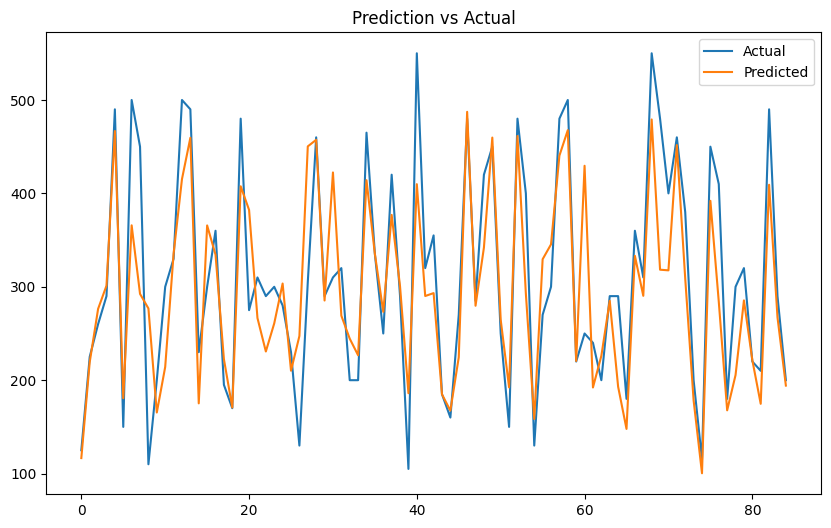

In [30]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
print(f"RMSE: {rmse:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(predictions_inv, label='Predicted')
plt.legend()
plt.title('Prediction vs Actual')
plt.show()

### Preparing prediction data

In [47]:
def prediction_data():
    weather_df = weather_data_processing()
    holiday_sg_24 = generate_holiday_df(2024)

    weather_df['date'] = pd.to_datetime(weather_df['date'])
    holiday_sg_24['calendar_date'] = pd.to_datetime(holiday_sg_24['calendar_date'])
    prediction_df = pd.merge(weather_df, holiday_sg_24, left_on='date', right_on='calendar_date', how='left')
    prediction_df.drop(columns=['weatherCondition', 'calendar_date'], inplace=True)
    prediction_df['day_of_week'] = prediction_df['date'].dt.day_name()
    prediction_df['week_of_year'] = pd.to_datetime(prediction_df['date']).dt.isocalendar().week
    prediction_df['temperature_category'] = pd.cut(prediction_df['Temperature'], bins=[-np.inf, 15, 25, np.inf], labels=['cold', 'mild', 'hot'])
    prediction_df.drop(columns='Temperature', inplace=True)
    prediction_df = pd.get_dummies(prediction_df, columns=['temperature_category'])
    prediction_df.rename(columns={'holiday_flg_sg': 'is_holiday'}, inplace=True)

    day_mapping = {
        'Monday': 1,
        'Tuesday': 2,
        'Wednesday': 3,
        'Thursday': 4,
        'Friday': 5,
        'Saturday': 6,
        'Sunday': 7
    }

    prediction_df['month'] = pd.to_datetime(prediction_df['date']).dt.month
    prediction_df['day'] = pd.to_datetime(prediction_df['date']).dt.day
    prediction_df['week_of_year'] = pd.to_datetime(prediction_df['date']).dt.isocalendar().week
    prediction_df['day_of_week'] = prediction_df['day_of_week'].replace(day_mapping)
    prediction_df.set_index('date', inplace=True)
    feature_df = feature_engineering()
    prediction_df = pd.merge(prediction_df, feature_df[['visitors_lag_1','visitors_lag_2','visitors_lag_3','visitors_lag_4','visitors_lag_5','visitors_lag_6', 'visitors_lag_7', 'rolling_mean_visitors', 'rolling_std_visitors', 'month', 'day']], on=['month', 'day'], how='left')

    return prediction_df

# You would need to define weather_data_processing(), generate_holiday_df(), and feature_engineering() properly for this to work.
X_predict = prediction_data()

(7, 18)

### generating daily prediction

In [84]:
def generate_daily_prediction():
    X_predict_scaled = loaded_scaler.transform(X_predict)
    X_predict_scaled = X_predict_scaled.reshape(X_predict_scaled.shape[0], 1, X_predict_scaled.shape[1])
    prediction_7days = model.predict(X_predict_scaled)
    prediction_7days_inv = scaler_y.inverse_transform(prediction_7days)
    prediction_7days_inv
    daily_prediction_df = pd.DataFrame(prediction_7days_inv, columns=['Predicted Values'])
    daily_prediction_df

    future_dates = pd.date_range(start=datetime.today(), periods=7, freq='D')
    future_predictions = pd.DataFrame({
        'date': future_dates,
        'predicted_visitors': np.round(daily_prediction_df['Predicted Values']).clip(upper=300) # maximum capacity of restairant = 300
    })
    daily_predictions_7days = future_predictions
    daily_predictions_7days['date'] = pd.to_datetime(daily_predictions_7days['date']).dt.date
    return daily_predictions_7days

generate_daily_prediction()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


,date,predicted_visitors
0,2024-04-24,205.0
1,2024-04-25,94.0
2,2024-04-26,98.0
3,2024-04-27,141.0
4,2024-04-28,252.0
5,2024-04-29,300.0
6,2024-04-30,300.0


In [82]:
def simulate_hourly_arrival(predicted_daily_visitors):
    time_intervals_1 = np.linspace(8, 16, 9)  # From 8 AM to 4 PM (9 hours)
    time_intervals_2 = np.linspace(17, 23, 7)  # From 5 PM to 11 PM (7 hours)
    time_intervals_strings = [f'{int(hour)}:00' for hour in np.concatenate((time_intervals_1, time_intervals_2), axis=None)]
    
    visitor_counts_1 = skewnorm.pdf(time_intervals_1, a=2, loc=12)  # Skew towards noon
    visitor_counts_2 = skewnorm.pdf(time_intervals_2, a=5, loc=19)  # Skew towards evening
    visitor_counts_1 = visitor_counts_1 / visitor_counts_1.max()  # Normalize to [0, 1]
    visitor_counts_2 = visitor_counts_2 / visitor_counts_2.max()
    
    visitor_counts_1 = np.round(visitor_counts_1 * predicted_daily_visitors * 0.6 / visitor_counts_1.sum()).astype(int)
    visitor_counts_2 = np.round(visitor_counts_2 * predicted_daily_visitors * 0.4 / visitor_counts_2.sum()).astype(int)
    
    hourly_counts = np.concatenate((visitor_counts_1, visitor_counts_2), axis=None)
    return time_intervals_strings, hourly_counts

def generate_and_merge_hourly_data(prediction_7days):
    output_df = pd.DataFrame(columns=['date', 'time', 'estimated_arrival_count'])

    for idx, row in prediction_7days.iterrows():
        time_strings, hourly_visitors = simulate_hourly_arrival(row['predicted_visitors'])
        day_df = pd.DataFrame({
            'date': [row['date']] * len(time_strings),
            'time': time_strings,
            'estimated_arrival_count': hourly_visitors
        })
        output_df = pd.concat([output_df, day_df], ignore_index=True)

    output_df['date'] = pd.to_datetime(output_df['date']).dt.date
    return output_df

# Assuming prediction_7days is your DataFrame containing dates and predicted visitors
result_df = generate_and_merge_hourly_data(generate_daily_prediction())
result_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


,date,time,estimated_arrival_count
0,2024-04-24,8:00,0
1,2024-04-24,9:00,0
2,2024-04-24,10:00,0
3,2024-04-24,11:00,1
4,2024-04-24,12:00,49
...,...,...,...
107,2024-04-30,19:00,48
108,2024-04-30,20:00,58
109,2024-04-30,21:00,13
110,2024-04-30,22:00,1
